# Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))

for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=177.96214929910425, mobile=True), User(purchased=True, time_on_site=88.77142838136207, mobile=True), User(purchased=False, time_on_site=206.4636516375143, mobile=False), User(purchased=False, time_on_site=29.098132454732266, mobile=True), User(purchased=False, time_on_site=121.31901043905673, mobile=True), User(purchased=True, time_on_site=252.71585168398843, mobile=True), User(purchased=False, time_on_site=37.64156638460579, mobile=True), User(purchased=False, time_on_site=196.56540064397205, mobile=True), User(purchased=False, time_on_site=63.29089486648284, mobile=True), User(purchased=False, time_on_site=38.83593916489007, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,177.962149,True
1,True,88.771428,True
2,False,206.463652,False
3,False,29.098132,True
4,False,121.319010,True


In [0]:
pd.crosstab(user_data['purchased'], user_data['mobile'],
            normalize='columns')

mobile,False,True
purchased,,
False,0.64,0.590667
True,0.36,0.409333


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.837572899494505,5.84871483386965,5.89387142833676,5.917373046090983,5.972024242704506,6.4083695088917825,6.672241521368259,6.67838918745148,6.690312289589944,6.847258171069406,...,586.2246846366413,586.5116188329254,588.4519986256901,590.571900884115,591.140713316367,592.2488862916335,592.3875823537362,594.573828486875,596.4978247827464,598.6911978983732
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,0,1,1,0,1,...,1,0,0,0,0,0,0,1,1,0
True,0,0,1,0,0,1,0,0,1,0,...,0,1,1,1,1,1,1,0,0,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.245, 124.408]","(124.408, 242.979]","(242.979, 361.55]","(361.55, 480.12]","(480.12, 598.691]"
purchased,,,,,
False,225,208,107,36,27
True,114,156,75,23,29


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.245, 124.408]","(124.408, 242.979]","(242.979, 361.55]","(361.55, 480.12]","(480.12, 598.691]"
purchased,,,,,
False,0.663717,0.571429,0.587912,0.610169,0.482143
True,0.336283,0.428571,0.412088,0.389831,0.517857


In [0]:
# That seems counter to our hypothesis
# More time on the site can have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.64,0.590667
True,0.36,0.409333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
# Dmitriy suggested checking correlations - good quick tool
user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,0.086108,0.043660
time_on_site,0.086108,1.000000,-0.561221
mobile,0.043660,-0.561221,1.000000


In [0]:
# Don extending crosstab
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            rownames=['time_bins'], colnames=['purchased', 'mobile'],
            normalize='index')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(5.245, 124.408]    0.100295  0.563422  0.020649  0.315634
(124.408, 242.979]  0.090659  0.480769  0.030220  0.398352
(242.979, 361.55]   0.164835  0.423077  0.109890  0.302198
(361.55, 480.12]    0.610169  0.000000  0.389831  0.000000
(480.12, 598.691]   0.482143  0.000000  0.517857  0.000000

In [0]:
help(pd.crosstab)

Help on function crosstab in module pandas.core.reshape.pivot:

crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)
    Compute a simple cross-tabulation of two (or more) factors. By default
    computes a frequency table of the factors unless an array of values and an
    aggregation function are passed
    
    Parameters
    ----------
    index : array-like, Series, or list of arrays/Series
        Values to group by in the rows
    columns : array-like, Series, or list of arrays/Series
        Values to group by in the columns
    values : array-like, optional
        Array of values to aggregate according to the factors.
        Requires `aggfunc` be specified.
    aggfunc : function, optional
        If specified, requires `values` be specified as well
    rownames : sequence, default None
        If passed, must match number of row arrays passed
    colnames : sequence, default None
 

In [0]:
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

    purchased  time_on_site  mobile                 bin
0        True    177.962149    True  (124.408, 242.979]
2       False    206.463652   False  (124.408, 242.979]
7       False    196.565401    True  (124.408, 242.979]
13       True    226.230891    True  (124.408, 242.979]
14      False    151.875137    True  (124.408, 242.979]
   purchased  time_on_site  mobile               bin
1       True     88.771428    True  (5.245, 124.408]
3      False     29.098132    True  (5.245, 124.408]
4      False    121.319010    True  (5.245, 124.408]
6      False     37.641566    True  (5.245, 124.408]
8      False     63.290895    True  (5.245, 124.408]
    purchased  time_on_site  mobile                bin
5        True    252.715852    True  (242.979, 361.55]
11      False    283.320605    True  (242.979, 361.55]
27       True    300.142868   False  (242.979, 361.55]
37      False    269.147978    True  (242.979, 361.55]
38      False    276.272503    True  (242.979, 361.55]
    purchased  t

In [0]:
dir(user_data.plot)

['__bytes__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_constructor',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_reset_cache',
 'area',
 'bar',
 'barh',
 'box',
 'density',
 'hexbin',
 'hist',
 'kde',
 'line',
 'pie',
 'scatter']

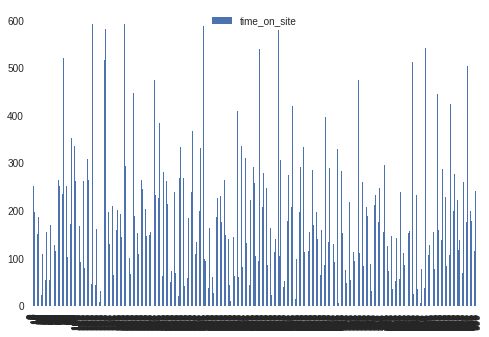

In [0]:
user_data.plot.bar();

In [0]:
print(1 + 1)
2 + 2

2


4

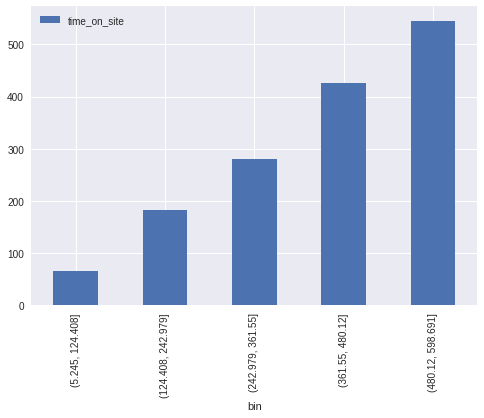

In [0]:
pd.pivot_table(
    user_data, values='time_on_site', index='bin').plot.bar();

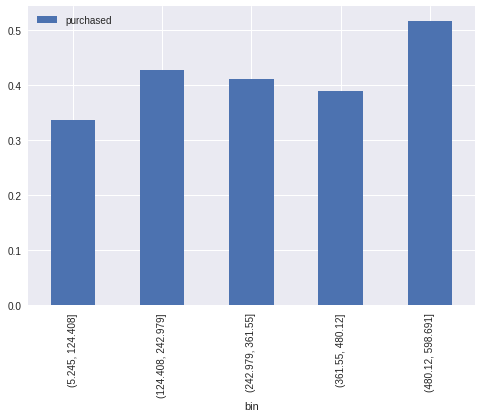

In [0]:
pd.pivot_table(user_data,values='purchased',
               index='bin').plot.bar()

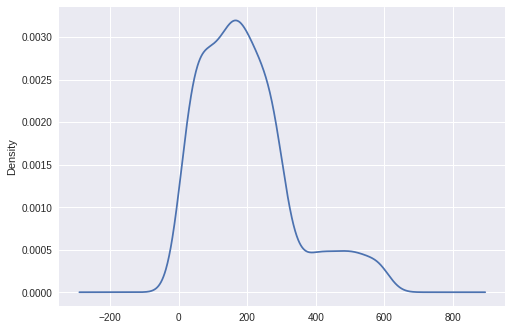

In [0]:
user_data['time_on_site'].plot.density()

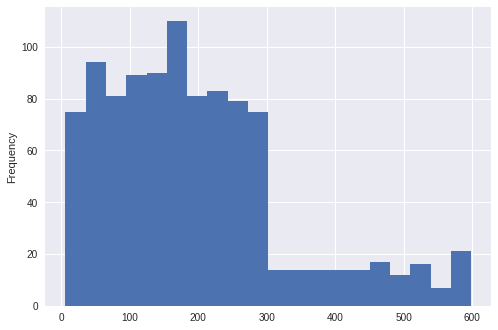

In [0]:
user_data['time_on_site'].plot.hist(bins=20)

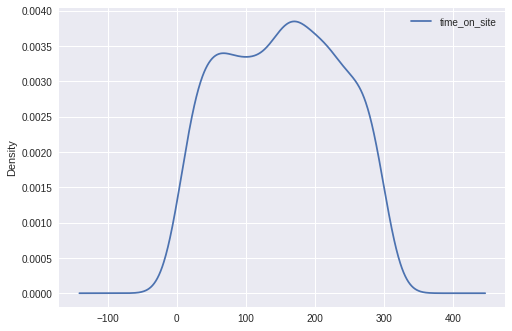

In [0]:
user_data[user_data['mobile'] == True].plot.density()

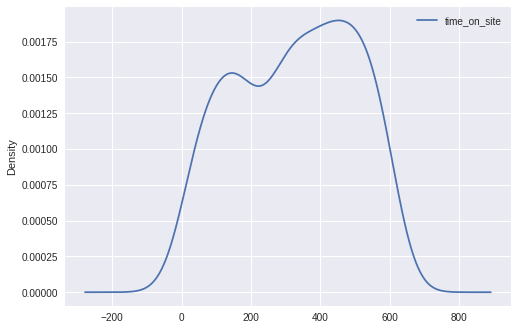

In [0]:
user_data[user_data['mobile'] == False].plot.density()

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased             False               True           
mobile                False     True      False     True 
time_on_site                                             
(5.245, 124.408]    0.21250  0.431151  0.077778  0.348534
(124.408, 242.979]  0.20625  0.395034  0.122222  0.472313
(242.979, 361.55]   0.18750  0.173815  0.222222  0.179153
(361.55, 480.12]    0.22500  0.000000  0.255556  0.000000
(480.12, 598.691]   0.16875  0.000000  0.322222  0.000000

In [0]:
help(ct.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      pandas.core.accessor.DirNamesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, font

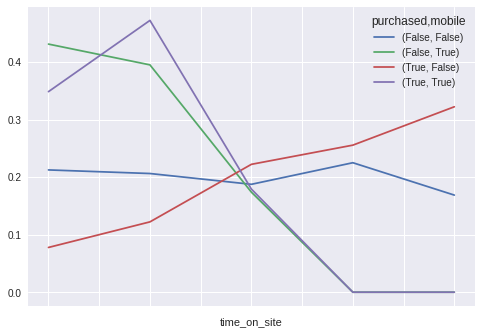

In [0]:
ct.plot()  # Works, but kinda weird to interpret

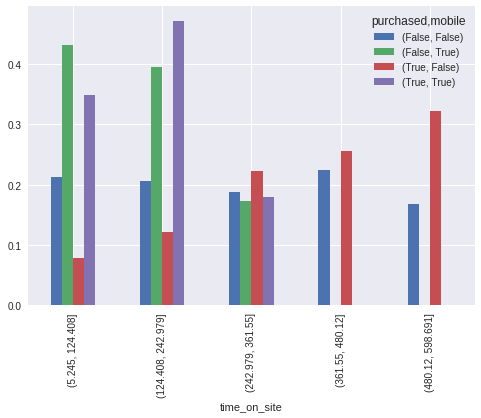

In [0]:
ct.plot(kind='bar')

In [0]:
ct2 = pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins],
                  normalize='columns')
ct2

mobile                  False                                       \
time_on_site (5.245, 124.408] (124.408, 242.979] (242.979, 361.55]   
purchased                                                            
False                0.829268               0.75               0.6   
True                 0.170732               0.25               0.4   

mobile                                                     True   \
time_on_site (361.55, 480.12] (480.12, 598.691] (5.245, 124.408]   
purchased                                                          
False                0.610169          0.482143          0.64094   
True                 0.389831          0.517857          0.35906   

mobile                                                              \
time_on_site (124.408, 242.979] (242.979, 361.55] (361.55, 480.12]   
purchased                                                            
False                  0.546875          0.583333              0.0   
True                   0.453125          0.416667              0.0   

mobile                          
time_on_site (480.12, 598.691]  
purchased                       
False                      0.0  
True                       0.0

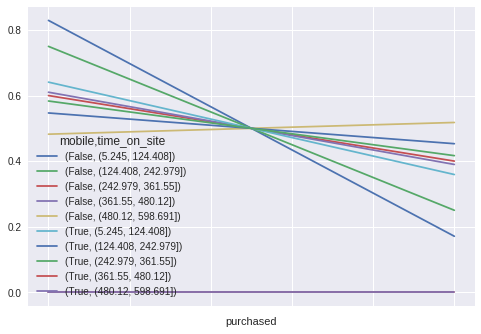

In [0]:
ct2.plot()  # Ehh too many dimensions/colors

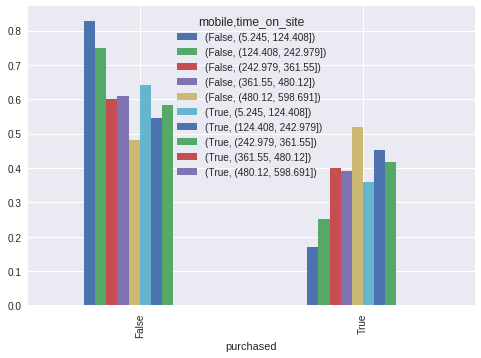

In [0]:
ct2.plot(kind='bar')

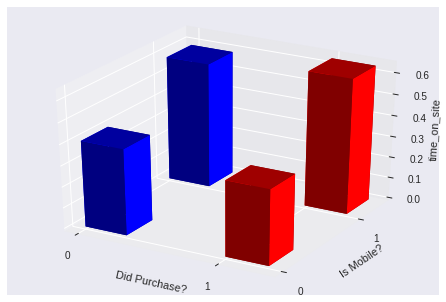

In [0]:
# Trying 3D barplot courtesy of Cole
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [0]:
# From Chris Luedtke
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df

,mobile,bin,purchased_num
0,False,"(5.245, 124.408]",0.170732
1,False,"(124.408, 242.979]",0.250000
2,False,"(242.979, 361.55]",0.400000
3,False,"(361.55, 480.12]",0.389831
4,False,"(480.12, 598.691]",0.517857
5,True,"(5.245, 124.408]",0.359060
6,True,"(124.408, 242.979]",0.453125
7,True,"(242.979, 361.55]",0.416667


In [0]:
help(pd.cut)  # On your own - try different binning
# In particular, try ensuring the mobile bin stops at 300

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
    Return indices of half-open bins to which each value of `x` belongs.
    
    Parameters
    ----------
    x : array-like
        Input array to be binned. It has to be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        If `bins` is an int, it defines the number of equal-width bins in the
        range of `x`. However, in this case, the range of `x` is extended
        by .1% on each side to include the min or max values of `x`. If
        `bins` is a sequence it defines the bin edges allowing for
        non-uniform bin width. No extension of the range of `x` is done in
        this case.
    right : bool, optional
        Indicates whether the bins include the rightmost edge or not. If
        right == True (the default), then the bins [1,2,3,4] indicate
        (1,2], (2,3], (3,4].
    labels : array or boole

In [0]:
# groupby - a useful utility
grouped_data = user_data.groupby(user_data['purchased'])
help(grouped_data)

Help on DataFrameGroupBy in module pandas.core.groupby object:

class DataFrameGroupBy(NDFrameGroupBy)
 |  Class for grouping and aggregating relational data. See aggregate,
 |  transform, and apply functions on this object.
 |  
 |  It's easiest to use obj.groupby(...) to use GroupBy, but you can also do:
 |  
 |  ::
 |  
 |      grouped = groupby(obj, ...)
 |  
 |  Parameters
 |  ----------
 |  obj : pandas object
 |  axis : int, default 0
 |  level : int, default None
 |      Level of MultiIndex
 |  groupings : list of Grouping objects
 |      Most users should ignore this
 |  exclusions : array-like, optional
 |      List of columns to exclude
 |  name : string
 |      Most users should ignore this
 |  
 |  Notes
 |  -----
 |  After grouping, see aggregate, apply, and transform functions. Here are
 |  some other brief notes about usage. When grouping by multiple groups, the
 |  result index will be a MultiIndex (hierarchical) by default.
 |  
 |  Iteration produces (key, group) tup

In [0]:
for key, group in grouped_data:
  print(key)
  print(group)

False
     purchased  time_on_site  mobile                 bin  purchased_num
2        False    206.463652   False  (124.408, 242.979]              0
3        False     29.098132    True    (5.245, 124.408]              0
4        False    121.319010    True    (5.245, 124.408]              0
6        False     37.641566    True    (5.245, 124.408]              0
7        False    196.565401    True  (124.408, 242.979]              0
8        False     63.290895    True    (5.245, 124.408]              0
9        False     38.835939    True    (5.245, 124.408]              0
10       False     13.854505    True    (5.245, 124.408]              0
11       False    283.320605    True   (242.979, 361.55]              0
12       False    526.112876   False   (480.12, 598.691]              0
14       False    151.875137    True  (124.408, 242.979]              0
16       False    186.029680    True  (124.408, 242.979]              0
17       False    122.958189    True    (5.245, 124.408]  

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import pandas as pd

csv_url = (
    'https://raw.githubusercontent.com/chrisluedtke/'
    'DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/'
    'persons.csv'
)

df = pd.read_csv(csv_url, usecols=[1, 2, 3])

In [21]:
df.head(10)

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182
5,58,103,165
6,55,161,107
7,21,188,37
8,55,216,79
9,50,127,267


In [22]:
df.isnull().sum()

age              0
weight           0
exercise_time    0
dtype: int64

In [23]:
df.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


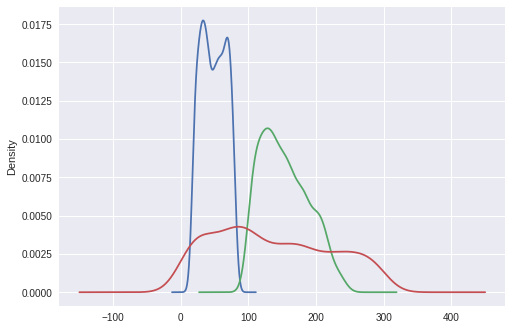

In [29]:
for col in ['age', 'weight', 'exercise_time']:
  df[col].plot.density()

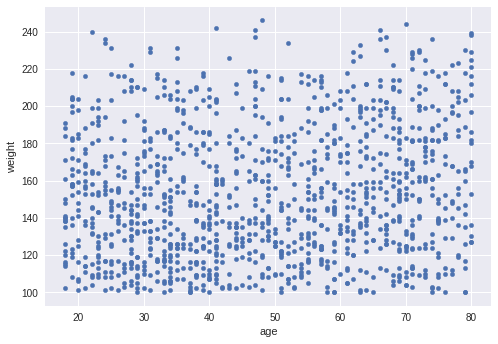

In [36]:
df.plot.scatter(x='age', y='weight')

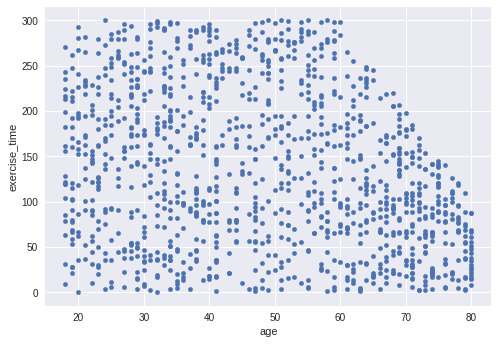

In [35]:
df.plot.scatter(x='age', y='exercise_time')

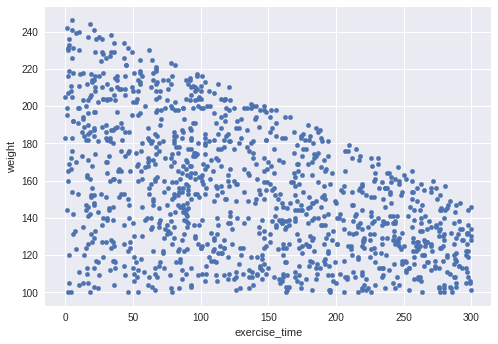

In [39]:
df.plot.scatter(x='exercise_time', y='weight')

In [0]:
def investigate_vars(df, col_0, col_1, col_2):
  df[f'{col_0}_bin'] = pd.cut(df[col_0], 10)
  
  grpd_corr = df.groupby(f'{col_0}_bin')[[col_1, col_2]].corr().reset_index()
  grpd_corr = grpd_corr.loc[grpd_corr[col_2] != 1, [f'{col_0}_bin', col_2]]

  corr_col_name = f'{col_1} & {col_2} correlation'
  grpd_corr.columns = [f'{col_0}_bin', corr_col_name]

  plt = grpd_corr.plot(x=f'{col_0}_bin', y=corr_col_name, xticks=range(0, 10, 2), ylim=(-1, 1))
  
  return plt

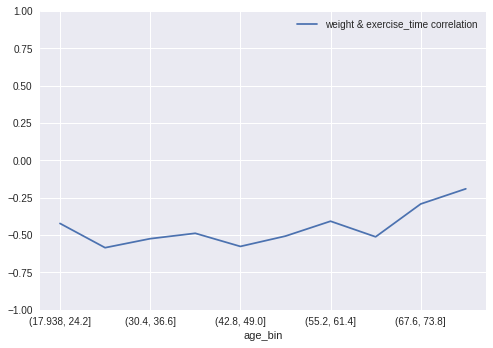

In [83]:
investigate_vars(df, 'age', 'weight', 'exercise_time')

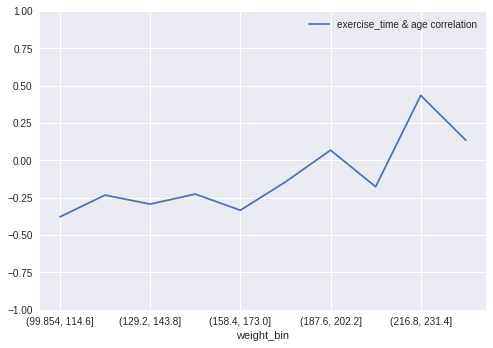

In [84]:
investigate_vars(df, 'weight', 'exercise_time', 'age')

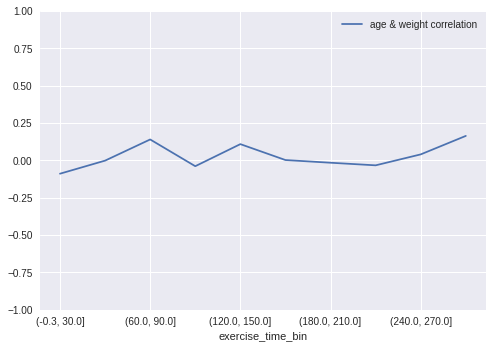

In [85]:
investigate_vars(df, 'exercise_time', 'age', 'weight')

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
  * all variables are continuous
2.  What are the relationships between the variables?
  * exercise time & weight -- moderate negative correlation
  * exercise time & age -- weak negatively correlation
  * age & weight -- weak positive correlation
3.  Which relationships are "real", and which spurious?
  * exercise time & weight -- correlation is present across age groups
  * age & weight -- spurious! correlation fluxuates by different exercise habbits

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)